In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import itertools
import warnings
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## Diccionario de datos
 
| Variable      |Definición                                                                | ¿Es utilizada? | Entrada/Salida |
|:--------------|:-------------------------------------------------------------------------|:--------------|:----------------|
|  id  |   Número correlativo de vuelos.                   | NO                              | -                             |
|  Airlines  | Nombre abreviado de la aerolinea.                | SI              | ENTRADA                                  |
|   Flight   | Número del vuelo.                            | NO              | -                                   |
|   AirportFrom   | De qué aeropuerto salió el vuelo.                         | Si                 | ENTRADA                         |
|    AirportTo  | A qué aeropuerto llegó el vuelo                 | SI           | ENTRADA                                        |
| DayOfWeek  | Día de la semana del vuelo.                 | SI           | ENTRADA                                                |         
| Time  | Hora de salida expresada en minutos.                  | SI           | ENTRADA                              |
| Length  | Duración del vuelo en minutos.                 | SI           | ENTRADA                              |
| Delay  | Si el vuelo esta demorado.                 | SI           | SALIDA                                      |

## Métrica:

## Completar....

In [2]:
data=pd.read_csv('Airlines.csv')
data.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [3]:
data.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.000000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.604461,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.500000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.000000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.500000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.000000,7814.000000,7.000000,1439.000000,655.000000,1.000000


## Limpieza y Pre Procesado:

Se eliminan las variables no utilizadas

In [4]:
df = data.drop(['id', 'Flight'],axis=1)
df.head()

,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,SFO,IAH,3,15,205,1
1,US,PHX,CLT,3,15,222,1
2,AA,LAX,DFW,3,20,165,1
3,AA,SFO,DFW,3,20,195,1
4,AS,ANC,SEA,3,30,202,0


Se eliminan datos atipicos

In [5]:
df= df.drop(df[(df['Length'] == 0)].index)

In [6]:
df.count()

Airline        539379
AirportFrom    539379
AirportTo      539379
DayOfWeek      539379
Time           539379
Length         539379
Delay          539379
dtype: int64

 ## Feature Engineering

In [7]:
## Funcion que calcula el momento del día
def momento_del_dia(hora):
    if hora >= 360 and hora < 720:
        return 'Mañana' ## MAÑANA
    elif hora >= 720 and hora < 1080:
        return 'Tarde' ## TARDE
    else:
        return 'Noche' ## NOCHE

In [8]:
df['MomentoDelDia'] = df['Time'].apply(momento_del_dia)

In [9]:
mapper = DataFrameMapper([
    (['Airline'], [OneHotEncoder()]),
    (['AirportFrom'], [OneHotEncoder()]),
    (['AirportTo'], [OneHotEncoder()]),
    (['DayOfWeek'], [StandardScaler()]),
    (['Time'], [StandardScaler()]),
    (['Length'], [StandardScaler()]),
    (['MomentoDelDia'], [OneHotEncoder()])
])

## Conjuntos de datos

In [10]:
train, not_train = train_test_split(df, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((323627, 8), (107876, 8), (107876, 8))

In [11]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        #'Precision': [],
        #'Recall': [],
        #'F1': [],        
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.Delay
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        #final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        #final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        #final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                     display_labels=['No Delay', 'Delay'])
            cm_plot.plot(cmap="Blues")
        
    display(pd.DataFrame(final_metrics, index=set_names))

## Primer modelo: Regresión logística

In [12]:
parameters = {'penalty': ['none', 'l2']}

clf = GridSearchCV(LogisticRegression(random_state=42), parameters, cv=5, scoring='accuracy')

gs_lr_model = Pipeline([
    ('mapper', mapper),
    ('classifier', clf),
])

gs_lr_model.fit(train, train.Delay)

/home/usuario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/usuario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/usuario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.war

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Airline'], [OneHotEncoder()]),
                                           (['AirportFrom'], [OneHotEncoder()]),
                                           (['AirportTo'], [OneHotEncoder()]),
                                           (['DayOfWeek'], [StandardScaler()]),
                                           (['Time'], [StandardScaler()]),
                                           (['Length'], [StandardScaler()]),
                                           (['MomentoDelDia'],
                                            [OneHotEncoder()])])),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(random_state=42),
                              param_grid={'penalty': ['none', 'l2']},
                              scoring='accuracy'))])

In [13]:
transformed_data = gs_lr_model.named_steps['mapper'].transform(train)
dimensiones = transformed_data.shape[1]
print("Cantidad de dimensiones:", dimensiones)

print("Cross-Validation Accuracy:", clf.best_score_)
print("Mejores Hiperparametros:", clf.best_params_)

Cantidad de dimensiones: 610
Cross-Validation Accuracy: 0.6463953837579255
Mejores Hiperparametros: {'penalty': 'none'}


'Regresión Logistica'

,Accuracy
train,0.648021
validation,0.644073


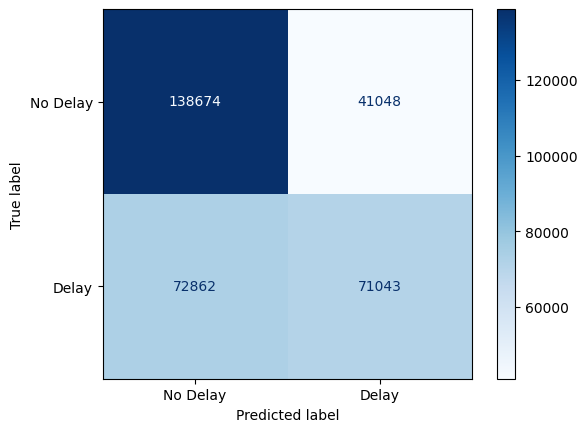

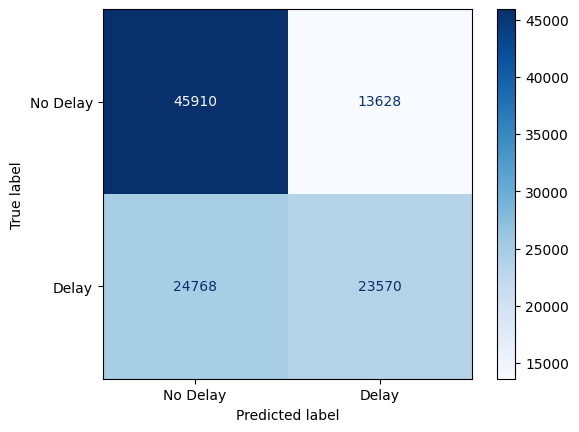

In [14]:
evaluate_model(gs_lr_model, title='Regresión Logistica', show_cm=True)

## Primer modelo: Regresión logística con PCA

In [ ]:
pca = PCA()

gs_lr_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca), 
])

gs_lr_model_pca.fit(train, train.Delay)

In [ ]:
# Definir qué fracción de la varianza se quiere mantener
var_frac = 0.95

# Calcular la suma cumulativa
cumsum = np.cumsum(pca.explained_variance_ratio_) 
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('Con {} dimensiones, preservamos el {} de la varianza.'.format(d, var_frac))

In [ ]:
parameters = {'penalty': ['none', 'l2']}

pca = PCA(n_components=d)

clf = GridSearchCV(LogisticRegression(random_state=42), parameters, cv=5, scoring='accuracy')

gs_lr_model_pca = Pipeline([
    ('mapper', mapper),
    ('pca', pca),
    ('classifier', clf),
    
])

gs_lr_model_pca.fit(train, train.Delay)


In [ ]:
transformed_data = gs_lr_model_pca.named_steps['mapper'].transform(train)
dimensiones = transformed_data.shape[1]
print("Cantidad de dimensiones:", dimensiones)

print("Cross-Validation Accuracy:", clf.best_score_)
print("Mejores Hiperparametros:", clf.best_params_)

In [ ]:
evaluate_model(gs_lr_model_pca, title='Regresión Logistica con PCA', show_cm=True)

## Segundo modelo: 

## Tercer modelo: